In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

In [2]:
# Import et concaténation des deux fichiers source
path = "../Data/"
df_source1 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset.csv")
df_source2 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset_part_2.csv")
df = pd.concat([df_source1, df_source2])

# Person ID 374 est un doublon
df.drop(index=373, inplace=True)

# On recrée l'index
df.index = df["Person ID"].values

# On retire l'ID du sujet qui ne nous sera pas utile
df.drop(columns="Person ID", inplace=True)

In [3]:
# Modification des noms de colonne, on supprime les espaces
mapper = {
    "Sleep Duration" : "SleepDuration",
    "Quality of Sleep" : "QualitySleep",
    "Physical Activity Level" : "PhysicalActivityLevel",
    "Stress Level" : "StressLevel",
    "BMI Category" : "BMI_Category",
    "Blood Pressure" : "BloodPressure",
    "Heart Rate" : "HeartRate",
    "Daily Steps" : "DailySteps",
    "Sleep Disorder" : "SleepDisorder"
}
df.rename(columns=mapper, inplace=True)

# On rectifie le type des variables (par défaut importées comme object)
new_types = {
    "Gender" : "string",
    "Occupation" : "string",
    "BMI_Category" : "string",
    "BloodPressure" : "string",
    "SleepDisorder" : "string"
}
df = df.astype(new_types)

In [4]:
# On sait qu'on n'a aucune valeur manquante pour SleepDisorder (None dans le fichier source)
# On crée une nouvelle catégorie pour les personnes sans trouble du sommeil
df.loc[df["SleepDisorder"].isna(), "SleepDisorder"] = "Healthy"

# On vérifie qu'on n'a aucune donnée manquante par ailleurs
df.isna().sum()

Gender                   0
Age                      0
Occupation               0
SleepDuration            0
QualitySleep             0
PhysicalActivityLevel    0
StressLevel              0
BMI_Category             0
BloodPressure            0
HeartRate                0
DailySteps               0
SleepDisorder            0
dtype: int64

In [5]:
# On a deux BMI_Category normales : "Normal Weight" et "Normal"
# On transforme les "Normal Weight" par "Normal"
df.replace("Normal Weight", "Normal", inplace=True)

# On sépare la tension en pression systolique et pression diastolique
for i in range(1,len(df)+1):
    pressure_list = df.loc[i,"BloodPressure"].split(sep='/')
    df.loc[i,"BloodPressureSystolic"] = int(pressure_list[0])
    df.loc[i,"BloodPressureDiastolic"] = int(pressure_list[1])
df.drop(columns="BloodPressure", inplace=True)

# On crée la liste des noms de variables quantitatives et qualitatives ordinales
quantitatives = ["Age", "SleepDuration", "PhysicalActivityLevel", "StressLevel", 
                 "HeartRate", "DailySteps", "BloodPressureSystolic", "BloodPressureDiastolic"]

# On prépare une nouvelle colonne binaire pour les sujets sains et qui présentent un trouble du sommeil
encoding = {"Healthy": "Healthy", "Insomnia": "Unhealthy", "Sleep Apnea": "Unhealthy"} # 3 labels : sain, insomnie, apnée du sommeil
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)

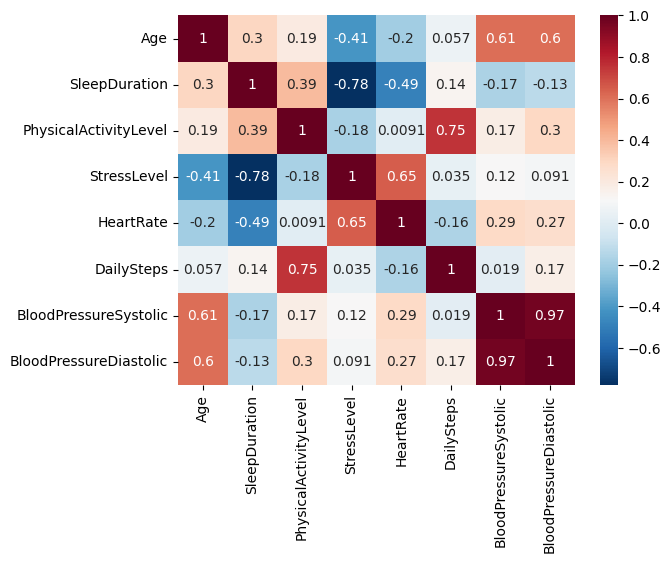

In [17]:
# On crée la matrice des corrélation pour les variables quantitatives et qualitatives ordinales
sns.heatmap(df[quantitatives].corr(), annot=True, cmap="RdBu_r")
plt.show()
# plt.savefig()

In [ ]:
# Encodage des variables catégorielles
def OneHot(df, columns):
    '''
    One Hot Encoding pour une variable catégorielle.
    '''
    for column in columns:
        for iter in df[column].unique():
            name = iter.replace(" ", "")
            df[name] = 0
            df.loc[df[column]==iter,name] = 1
    
    df.drop(columns=columns, inplace=True)

    return df

df = OneHot(df, ["Gender", "Occupation", "BMI_Category"])

# Encodage de la variable à expliquer SleepDisorder
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 2} # 3 labels : sain, insomnie, apnée du sommeil
df["SleepDisorderEncoded"] = df["SleepDisorder"].map(encoding)
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 1} # 2 labels : avec vs sans trouble
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)
df.drop(columns="SleepDisorder", inplace=True)

# Découpage en train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df["SleepDisorderEncoded"])

In [ ]:
# On n'essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes
SVM_HAS = SVC(kernel="linear", max_iter=100000000, random_state=42).fit(X_train, y_train["HasSleepDisorder"])
pred_train = SVM_HAS.predict(X_train)
pred_test = SVM_HAS.predict(X_test)
print(len(y_test[y_test["HasSleepDisorder"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
# On n'essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes#
SVM_MULTI = SVC(kernel="linear", max_iter=100000000, random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = SVM_MULTI.predict(X_train)
pred_test = SVM_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
TREE_MULTI = DecisionTreeClassifier(random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = TREE_MULTI.predict(X_train)
pred_test = TREE_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
TREE_MULTI = DecisionTreeClassifier(ccp_alpha=0.01, random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = TREE_MULTI.predict(X_train)
pred_test = TREE_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
FOREST_MULTI = RandomForestClassifier(random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = FOREST_MULTI.predict(X_train)
pred_test = FOREST_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
BOOSTING_MULTI = GradientBoostingClassifier(random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = BOOSTING_MULTI.predict(X_train)
pred_test = BOOSTING_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
MLP_MULTI = MLPClassifier(hidden_layer_sizes=(16,), activation='relu', solver='adam', max_iter=1000, random_state=42)
MLP_MULTI.fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = MLP_MULTI.predict(X_train)
pred_test = MLP_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()